## Lab 3

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [0]:
import string
import os
import numpy as np
import torch, torch.nn as nn
import random
from torch.autograd import Variable
import torch.nn.functional as F
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [50]:
if not os.path.exists('data.txt'):
    !wget https://raw.githubusercontent.com/AnastasiyaFokina/ML_study_public/master/data.txt

with open('data.txt', 'r') as iofile:
    text = iofile.readlines()
    
##TEXT_START = 45
#TEXT_END = -368
#text = text[TEXT_START : TEXT_END]
#assert len(text) == 2616
len(text)

--2020-06-14 19:24:14--  https://raw.githubusercontent.com/AnastasiyaFokina/ML_study_public/master/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 301043 (294K) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>] 293.99K  --.-KB/s    in 0.02s   

2020-06-14 19:24:16 (14.0 MB/s) - ‘data.txt’ saved [301043/301043]



1711

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [0]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

#assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
##assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
#print('OK!')

### Data loading: "Евгений Онегин"


In [0]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines(
        
    )
    
text = [x.replace('\t\t', '') for x in text]

--2020-05-25 11:50:22--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.05s   

2020-05-25 11:50:22 (5.08 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [0]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [0]:
tokens = sorted(set(text))

In [53]:
len(tokens)

90

In [55]:
tokens

['\n',
 ' ',
 '!',
 '"',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '^',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'h',
 'i',
 'j',
 'k',
 'm',
 'n',
 'o',
 'p',
 'r',
 's',
 'v',
 'x',
 'y',
 '{',
 '|',
 '«',
 '°',
 '»',
 'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'щ',
 'ъ',
 'ы',
 'ь',
 'э',
 'ю',
 'я',
 'ё',
 '—',
 '•',
 '™']

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [0]:
# dict <index>:<char>
# Your great code here
idx_to_token = dict(zip(range(len(tokens)), tokens))
# dict <char>:<index>
# Your great code here
token_to_idx = dict(zip(tokens, range(len(tokens))))

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [0]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens, emb_size=90, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.fc = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.num_units)
        out = self.fc(out)
        return out, hidden
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(1, batch_size, self.num_units)).to(device)

In [0]:
def get_batches(arr, batch_size, seq_length):
    
    batch_size_total = batch_size * seq_length
    # total number of batches we can make
    n_batches = len(arr)//batch_size_total
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    # Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))
    
    # iterate through the array, one sequence at a time
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

In [0]:
def one_hot_encode(arr, n_labels):   
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    return one_hot

In [0]:
encoded = np.array([token_to_idx[ch] for ch in text])

In [0]:
def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, 
          temperature=0.2, lstm=False):
    
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    val_idx = int(len(data)*(0.9))
    data, val_data = data[:val_idx], data[val_idx:]
    
    counter = 0
    n_chars = len(tokens)
    for e in range(epochs):
        h = net.initial_state(batch_size)
        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            inputs, targets = inputs.to(device), targets.to(device)
            net.zero_grad()
            
            if lstm:
                h = tuple([each.data for each in h])
            else:
                h = h.detach()
                
            output, h = net(inputs, h)
            loss = criterion(output, targets.view(batch_size*seq_length).long())
            loss.backward()
            
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
        
            if counter % 100 == 0:
                # Get validation loss
                val_h = net.initial_state(batch_size)
                val_losses = []
                net.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    if lstm:
                        val_h = tuple([each.data for each in val_h])
                    else:
                        val_h = val_h.detach()
                    
                    inputs, targets = x, y
                    inputs, targets = inputs.to(device), targets.to(device)

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size*seq_length).long())
                
                    val_losses.append(val_loss.item())
                
                net.train() # reset to train mode after iterationg through validation data
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))
                train_loss.append(loss.item())
                test_loss.append(np.mean(val_losses))

In [0]:
def predict(net, char, h=None, temperature=0.2, lstm=False):
        x = np.array([[token_to_idx[char]]])
        x = one_hot_encode(x, len(tokens))
        inputs = torch.from_numpy(x).to(device)
        
        if lstm:
            h = tuple([each.data for each in h])
        else:
            h = h.detach()
            
        out, h = net(inputs, h)
        
        p = F.softmax(out/temperature, dim=1).data
        p = p.cpu().numpy().squeeze()
        char = np.random.choice(len(tokens), p=p/p.sum())
        return idx_to_token[char], h

def sample(net, size, prime='the', temperature=0.2, lstm=False):
        
    net.to(device)
    net.eval()
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.initial_state(1)
    for ch in prime:
        char, h = predict(net, ch, h, temperature, lstm)

    chars.append(char)
    
    for ii in range(size):
        char, h = predict(net, chars[-1], h, temperature, lstm)
        chars.append(char)

    return ''.join(chars)

In [62]:
train_loss, test_loss = [], []
net = CharRNNLoop(len(tokens), rnn_num_units=256).to(device)
train(net, encoded, epochs=200, batch_size=100, seq_length=100)

Epoch: 8/200... Step: 100... Loss: 3.1088... Val Loss: 3.1212
Epoch: 15/200... Step: 200... Loss: 2.7469... Val Loss: 2.7392
Epoch: 22/200... Step: 300... Loss: 2.4941... Val Loss: 2.5057
Epoch: 29/200... Step: 400... Loss: 2.3485... Val Loss: 2.3740
Epoch: 36/200... Step: 500... Loss: 2.2287... Val Loss: 2.2807
Epoch: 43/200... Step: 600... Loss: 2.1434... Val Loss: 2.2048
Epoch: 50/200... Step: 700... Loss: 2.0958... Val Loss: 2.1396
Epoch: 58/200... Step: 800... Loss: 1.9949... Val Loss: 2.0821
Epoch: 65/200... Step: 900... Loss: 1.8563... Val Loss: 2.0373
Epoch: 72/200... Step: 1000... Loss: 1.7892... Val Loss: 2.0022
Epoch: 79/200... Step: 1100... Loss: 1.7542... Val Loss: 1.9763
Epoch: 86/200... Step: 1200... Loss: 1.7117... Val Loss: 1.9593
Epoch: 93/200... Step: 1300... Loss: 1.6682... Val Loss: 1.9633
Epoch: 100/200... Step: 1400... Loss: 1.6756... Val Loss: 1.9362
Epoch: 108/200... Step: 1500... Loss: 1.6176... Val Loss: 1.9460
Epoch: 115/200... Step: 1600... Loss: 1.5098... 

In [0]:
from matplotlib import pyplot as plt
def plot_train_process(train_loss, test_loss):
  fig, axes = plt.subplots(1, 1,figsize=(15,5))

  axes.set_title("Loss")
  axes.plot(train_loss, label='train')
  axes.plot(test_loss, label='test')
  axes.legend()

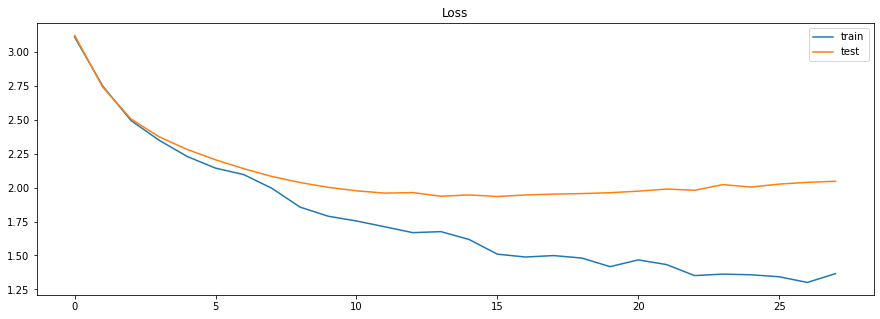

In [64]:
plot_train_process(train_loss, test_loss)

In [0]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

hide my will in thine?
  shall will in of the simend that in my sime the seave the seave the sorll the soren the sange the seall seares and and the fart the wirl the seall the songh whing that thou hall will thoun the soond beare the with that sare the simest me the fart the wirl the songre the with thy seart so for shat so for do the dost the sing the sing the sing the soond canding the sack and the farling the wirl of sore sich and that with the seare the seall so fort the with the past the wirl the simen the wirl the sores the sare


In [65]:
print(sample(net, 5000, prime='я'))

я фолософии невозможно своеми проблема самого познании наука, прокрасное полазательного заменать предложение проблематель отношения. онили она результат человека. в том, что он положение и правильное проиточение своих существуют просто в средневековые совеем изации, идеаленая в сознании и постерии истонии науко идеял визвол так и в сознании — это значительности. в нешех стотой из оределия — это мероду для кентриз на конечно разум ответственно современной философии в философии науки (протовом состоит и полотический предложений философии совершенном колорая марес образализма в философии неческих сперина должной философской проблемы природы из тако, человек современной философии понятие проблема самом постадить полагать мы предложение проблематель теком подемнализма в философии неукой и постмаление образности. направление тем на поробого изменить предложения должно быть произобложения и прекрасное как истинность философии понимание предложения и практики мырадательное положения делоким мо

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [0]:
# Your beautiful code here
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens, emb_size=90, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True, num_layers=2, dropout=0.5)
        self.fc = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.num_units)
        out = self.fc(out)
        return out, hidden
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return (Variable(torch.zeros(2, batch_size, self.num_units)).to(device),
                Variable(torch.zeros(2, batch_size, self.num_units)).to(device))

In [69]:
train_loss, test_loss = [], []
net = CharLSTMLoop(len(tokens), rnn_num_units=512).to(device)
train(net, encoded, lstm=True, epochs=100, batch_size=100, seq_length=100)

Epoch: 8/100... Step: 100... Loss: 3.1912... Val Loss: 3.2125
Epoch: 15/100... Step: 200... Loss: 2.8915... Val Loss: 2.8794
Epoch: 22/100... Step: 300... Loss: 2.6120... Val Loss: 2.5934
Epoch: 29/100... Step: 400... Loss: 2.4081... Val Loss: 2.4053
Epoch: 36/100... Step: 500... Loss: 2.2318... Val Loss: 2.2517
Epoch: 43/100... Step: 600... Loss: 2.0938... Val Loss: 2.1183
Epoch: 50/100... Step: 700... Loss: 2.0376... Val Loss: 2.0067
Epoch: 58/100... Step: 800... Loss: 1.8857... Val Loss: 1.9147
Epoch: 65/100... Step: 900... Loss: 1.7284... Val Loss: 1.8393
Epoch: 72/100... Step: 1000... Loss: 1.6437... Val Loss: 1.7822
Epoch: 79/100... Step: 1100... Loss: 1.6166... Val Loss: 1.7379
Epoch: 86/100... Step: 1200... Loss: 1.5377... Val Loss: 1.7078
Epoch: 93/100... Step: 1300... Loss: 1.4885... Val Loss: 1.6856
Epoch: 100/100... Step: 1400... Loss: 1.4829... Val Loss: 1.6534


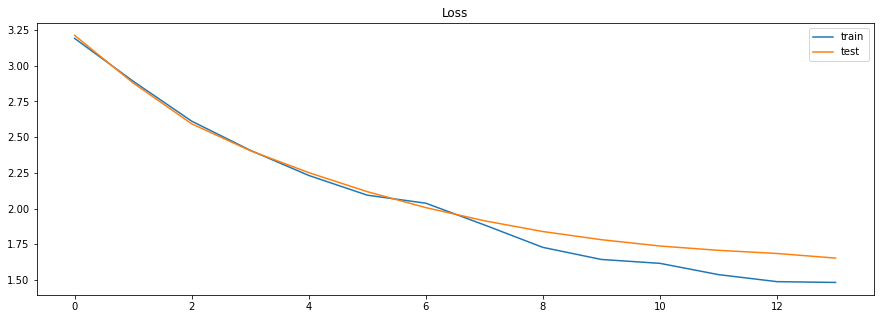

In [70]:
plot_train_process(train_loss, test_loss)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [71]:
# Text generation with different temperature values here
for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print('-----Current temp: {}------'.format(temp))
    print(sample(net, 500, prime='a', temperature=temp, lstm=True))

-----Current temp: 0.1------
aвов и противоречий ответственность состоит и том, что в сознания и состоит из общественного принципа и противоречий в своей принцип и противоречий отношении к науки, в состоит из том, что в сознания и противоречий в сознания и противоречий в сознания и противоречий в стремились как и всего в состоит и том, что в состоит и том, что в сознания и состоит из общественного принципа и противоречий и становится в противоречий в своего совершенность сократа на противоречий и противоречий отношения сознан
-----Current temp: 0.2------
aвов принципиальными предложения философии на противоречий в противоречий общественного и своих принципа и противоречий в своего совершенность и противоречий ответственность и противоречий отношении в сознания. на пример называют своих принципы и противоречий добродетельность в этой связи с предложения совершинся на противоречий и противоречия и поставить на противоречий к тем не не столько они не страницу как своего не состоит и том, 

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [0]:
# Saving and loading code here
torch.save(net.state_dict(), './model.pt')
loaded_model = CharLSTMLoop(len(tokens), rnn_num_units=512).to(device)
loaded_model.load_state_dict(torch.load('./model.pt'))
loaded_model.eval()
print(sample(loaded_model, 500, lstm=True))

then shall be thy sightle souls fair from my mind,
    the our of this will be a carter of thee,
    when thou art but the dear doth love and thee,
    and then thou hast thou shalt stall be thy mind,
    the stars of self a former than the stars
  of this the looks of that the shame defarted.
  the world with flatter's with this i prove
  after that fear from fair as the part:
    and there where beauty's such a sead affect,
  or that thou shalt stars my love and thee,
    and thou art fortune's sh


Не очень понятно, нужен ли отчет, но пусть будет. 

Решила взять Шекспира, скорее из желания работать с английским языком.

Очевидны преимущества LSTM как из сэмплов, так и из графиков.

Немного неочевдны итоги с экспериментов с температурой: мной отмечены рост разнообразия пунктуации с ростом температуры- появляются восклицательные знаки, двоеточия, ; Также появлятся попытки притяжательных прилагательных. Разнообразие слов оценить затрудняюсь.

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)